## Simple text classification example with `keras`
<hr>

1. load, split, and preprocess data 
2. define network structure 
3. train classifier 
4. generate predictions on holdout set 
5. evaluate performance

*Note: Adapted from Sec 3.4 of *DLwP* (Chollet 2018)*

**`TODO`**:
- replace `imdb.load_data()` with text --> dtm workflow
- make note of relevant hypers 
- write viz wrappers for cleaner plotting

### 1. Load, split, and preprocess data
<hr>

In [1]:
from keras.datasets import imdb

# restrict vocab size to 10k words (not necessary but speeds up dev)
vocab_n = 10000

# movie reviews w binary sentiment labels ship w keras 
# NOTE: they come tokenized, w words replaced by int indices
(train_X, train_y), (test_X, test_y) = imdb.load_data(num_words=vocab_n)

Using TensorFlow backend.


In [2]:
# check shape of data 
print('train input shape:', train_X.shape)
print('train labels shape:', train_y.shape)

print('test input shape:', test_X.shape)
print('test labels shape:', test_y.shape)

train input shape: (25000,)
train labels shape: (25000,)
test input shape: (25000,)
test labels shape: (25000,)


In [3]:
import numpy as np

# function to construct binary DTM from int-encoded docs 
# NOTE: setting `vocab_n` above simplifies this step
# more typical workflow uses `keras.preprocessing.text.Tokenizer` class 
def vectorize_sequences(sequences, dim):
  results = np.zeros((len(sequences), dim))
  for i, sequence in enumerate(sequences):
    results[i, sequence] = 1.
  return results


# vectorize int-sequence encoded documents (cast to binary DTM)
train_X = vectorize_sequences(train_X, dim=vocab_n)
test_X = vectorize_sequences(test_X, dim=vocab_n)

# preprocess the labels too (convert to np float arrays)
train_y = np.asarray(train_y).astype('float32')
test_y = np.asarray(test_y).astype('float32')

### 2. Define network structure, compile network
<hr>

In [4]:
from keras import models
from keras import layers

# instantiate sequential model 
model = models.Sequential()

# add two 16-unit densely connected hidden layers
model.add(layers.Dense(16, activation='relu', input_shape=(vocab_n, )))
model.add(layers.Dense(16, activation='relu'))

# output layer sigmoid, produces scalar probability for each input
model.add(layers.Dense(1, activation='sigmoid'))

In [5]:
# vanilla choices for binary clf, see DLwP S3.4.3 for discussion
optimizer = 'rmsprop'
loss = 'binary_crossentropy'
metrics = ['accuracy']

model.compile(optimizer=optimizer, loss=loss, metrics=metrics)

### 3. Train classifier
<hr>

In [6]:
# use part of train data for continuous validation during train
valset_size = 10000

valset_X = train_X[:valset_size]
partial_train_X = train_X[valset_size:]

valset_y = train_y[:valset_size]
partial_train_y = train_y[valset_size:]

In [7]:
# more epochs usually leads to higher train accuracy 
# (but also makes overfitting much more likely)
epochs = 10

# flow thru nn in `batch_size` mini-batches during train 
batch_size = 512

# note that `history` object has several useful methods 
history = model.fit(partial_train_X, partial_train_y,
                    epochs=epochs, batch_size=batch_size,
                    validation_data=(valset_X, valset_y))

Train on 15000 samples, validate on 10000 samples
Epoch 1/10
15000/15000 [==============================] - 6s 413us/step - loss: 0.4955 - acc: 0.7959 - val_loss: 0.3704 - val_acc: 0.8719
Epoch 2/10
15000/15000 [==============================] - 6s 393us/step - loss: 0.2948 - acc: 0.9047 - val_loss: 0.2986 - val_acc: 0.8905
Epoch 3/10
15000/15000 [==============================] - 5s 353us/step - loss: 0.2154 - acc: 0.9283 - val_loss: 0.3089 - val_acc: 0.8715
Epoch 4/10
15000/15000 [==============================] - 5s 348us/step - loss: 0.1737 - acc: 0.9435 - val_loss: 0.2829 - val_acc: 0.8850
Epoch 5/10
15000/15000 [==============================] - 6s 379us/step - loss: 0.1410 - acc: 0.9543 - val_loss: 0.2866 - val_acc: 0.8853
Epoch 6/10
15000/15000 [==============================] - 7s 444us/step - loss: 0.1140 - acc: 0.9655 - val_loss: 0.3084 - val_acc: 0.8814
Epoch 7/10
15000/15000 [==============================] - 7s 472us/step - loss: 0.0967 - acc: 0.9712 - val_loss: 0.3152 - 

### 4. Generate predictions 
<hr>

In [8]:
# function to convert a probability in [0, 1] into a binary value 
def prob_to_binary(prob, threshold=.5, ret_type=bool):
  assert 0 <= prob <= 1
  assert 0 <= threshold <= 1
  return ret_type(prob > threshold)


# generate probabilistic predictions, convert them to binary 
test_probs = model.predict(test_X)
test_preds = [prob_to_binary(prob) for prob in test_probs]

### 5. Evaluate model performance
<hr>

In [9]:
from sklearn.metrics import confusion_matrix

confusion_matrix(test_y, test_preds)

array([[10968,  1532],
       [ 1872, 10628]])

In [10]:
from sklearn.metrics import accuracy_score, f1_score
from sklearn.metrics import precision_score, recall_score


eval_metrics = [f1_score, precision_score, recall_score, accuracy_score]

for func in eval_metrics:
  print(f'{func.__name__} on test: {round(func(test_y, test_preds), 3)}')

f1_score on test: 0.862
precision_score on test: 0.874
recall_score on test: 0.85
accuracy_score on test: 0.864


In [11]:
### TODO: SWAP OUT MESS IN THIS + NEXT CHUNK W IMPORT + CALL TO:
###     >> plotting_util.plot_keras_loss_accuracy_curves(history)

# want to inspect loss and accuracy curves during train 
losses = history.history['loss']
val_losses = history.history['val_loss']

accs = history.history['acc']
val_accs = history.history['val_acc']

epoch_idxs = range(1, len(accs) + 1)

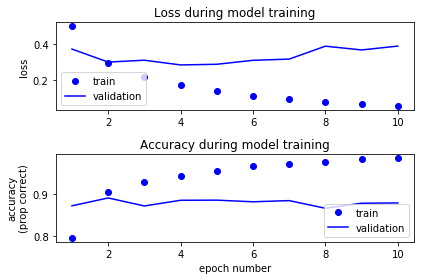

In [12]:
%matplotlib inline
import matplotlib.pyplot as plt

# plot loss curves for train and validation sets during training 
plt.subplot(2, 1, 1)
plt.plot(epoch_idxs, losses, 'bo', label='train')
plt.plot(epoch_idxs, val_losses, 'b', label='validation')
plt.title('Loss during model training')
plt.ylabel('loss')
plt.legend(loc=3)

# plot accuracy curves for train and validation sets during training 
plt.subplot(2, 1, 2)
plt.plot(epoch_idxs, accs, 'bo', label='train')
plt.plot(epoch_idxs, val_accs, 'b', label='validation')
plt.title('Accuracy during model training')
plt.xlabel('epoch number'); plt.ylabel('accuracy\n(prop correct)')
plt.legend(loc=4)

# check `plt.rcParams.keys()` to tune graphical params 
plt.rcParams['figure.dpi'] = 80
plt.tight_layout()
plt.show()